In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/f2-dataset/F2_test.csv


In [2]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-
#
# @Author: Mingyeong Yang (mmingyeong@kasi.re.kr)
# @Date: 2024-07-02
# @Filename: PhotoZ_RandomForest.ipynb
# This project was conducted at the 2024 KIAS Summer School on Extragalactics and Cosmology.

## Let’s try to measure photometric redshifts based on randomForest technique

### Goals
- F2의 관측값을 사용하여 측광 적색이동값을 추정하기. (Please use 5-bands magnitudes (UGRIZ))
- Make a comparison between photo-z and spec-z
- Make a cone diagram based on photo-z and spec-z  

### Data
Sample : SHELS/F2 (Geller et al. 2016)  
• Complete spectroscopic survey to R < 20.6   
• SDSS photometry (PETROMAG_*, UGRIZ)  

### Method 
Randomforest?
- 앙상블 학습(Ensemble Learning) 방법 중 하나로, 여러 개의 결정 트리(Decision Tree)를 사용하여 학습하고 예측하는 머신러닝 알고리즘
- Random Sampling
- Choose random features

In [3]:
f2_dataset = pd.read_csv('/kaggle/input/f2-dataset/F2_test.csv')
f2_dataset.shape

/tmp/ipykernel_1867/1916854730.py:1: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  f2_dataset = pd.read_csv('/kaggle/input/f2-dataset/F2_test.csv')


(87450, 34)

In [4]:
cols = f2_dataset.columns.to_list()
cols

['Unnamed: 0',
 'OBJID',
 'RA',
 'DEC',
 'PETROMAG_U',
 'PETROMAGERR_U',
 'PETROMAG_G',
 'PETROMAGERR_G',
 'PETROMAG_R',
 'PETROMAGERR_R',
 'PETROMAG_I',
 'PETROMAGERR_I',
 'PETROMAG_Z',
 'PETROMAGERR_Z',
 'EXTINCTION_U',
 'EXTINCTION_G',
 'EXTINCTION_R',
 'EXTINCTION_I',
 'EXTINCTION_Z',
 'K_PETROCOR_U_Z00',
 'K_PETROCOR_G_Z00',
 'K_PETROCOR_R_Z00',
 'K_PETROCOR_I_Z00',
 'K_PETROCOR_Z_Z00',
 'Z',
 'ZERR',
 'Z_SDSS_SPECFILE',
 'MASS',
 'MASS_LERR',
 'MASS_HERR',
 'PM_Z',
 'PM_ZERR',
 'PM_VDISP',
 'PM_VDISPERR']

## Columns
- OBJID: Object ID # ID
- RA: 천체의 적경 (Right Ascension)
- DEC: 천체의 적위 (Declination)
- PETROMAG_U, PETROMAG_G, PETROMAG_R, PETROMAG_I, PETROMAG_Z: Photometric Magnitudes in (U, G, R, I, Z) bands
- EXTINCTION_U, EXTINCTION_G, EXTINCTION_R, EXTINCTION_I, EXTINCTION_Z: Extinction in (U, G, R, I, Z) bands
- K_PETROCOR_U_Z00, K_PETROCOR_G_Z00, K_PETROCOR_R_Z00, K_PETROCOR_I_Z00, K_PETROCOR_Z_Z00: Photometric Magnitudes correction value
- Z: Redshift # Lable
- ZERR: Redshift error
- Z_SDSS_SPECFILE: Redshift measurement에 사용된 SDSS 스펙트럼 파일
- MASS: 천체의 질량
- MASS_LERR, MASS_HERR: 질량 측정의 하한 오차와 상한 오차
- PM_Z: Photometric Redshift
- PM_ZERR: Photometric Redshift error
- PM_VDISP: Photometric Velocity Dispersion
- PM_VDISPERR: Photometric Velocity Dispersion error

### 여기서 우리가 예측하고 싶은 값은 "PM redshift".
### 정답은 분광 적색이동값이기때문에 Z column이 Lable이 될 것임
#### Lable과 ID를 제외한 features들 중 Photo-Z를 예측하기위해 사용될 column을 먼저 선택한 후 Randomforest 알고리즘을 사용하여 학습시켜보자

## Features
- PETROMAG_U, PETROMAG_G, PETROMAG_R, PETROMAG_I, PETROMAG_Z: Photometric Magnitudes in (U, G, R, I, Z) bands
- EXTINCTION_U, EXTINCTION_G, EXTINCTION_R, EXTINCTION_I, EXTINCTION_Z: Extinction in (U, G, R, I, Z) bands
- K_PETROCOR_U_Z00, K_PETROCOR_G_Z00, K_PETROCOR_R_Z00, K_PETROCOR_I_Z00, K_PETROCOR_Z_Z00: Photometric Magnitudes correction value
- Z: Redshift # Lable
- ZERR: Redshift error
- Z_SDSS_SPECFILE: Redshift measurement에 사용된 SDSS 스펙트럼 파일
- MASS: 천체의 질량
- MASS_LERR, MASS_HERR: 질량 측정의 하한 오차와 상한 오차

## Lable
- PM_Z: Photometric Redshift
- PM_ZERR: Photometric Redshift error
- PM_VDISP: Photometric Velocity Dispersion
- PM_VDISPERR: Photometric Velocity Dispersion error

### 여기서 우리가 예측하고 싶은 값은 "redshift"이기때문에 Z column이 Lable이 될 것임.
#### 5-bands magnitudes (UGRIZ) 데이터만 사용해서 Randomforest 알고리즘을 사용하여 학습시켜보자

In [5]:
mag_df = f2_dataset[['OBJID', 'PETROMAG_U', 'PETROMAG_G', 'PETROMAG_R', 'PETROMAG_I', 'PETROMAG_Z', 'Z']]
mag_df

,OBJID,PETROMAG_U,PETROMAG_G,PETROMAG_R,PETROMAG_I,PETROMAG_Z,Z
0,1237661381695570379,21.323261,20.854404,19.707392,19.273945,18.714960,0.337797
1,1237661381695570380,20.935017,20.528833,19.854614,19.613590,19.129480,0.273486
2,1237661381695570634,24.547445,22.835169,21.154341,20.286835,20.287001,-99.000000
3,1237661381695570691,21.752686,21.104000,20.348263,20.078228,19.590927,0.284007
4,1237661381695570866,23.264183,22.053299,20.738749,19.300367,18.546480,-99.000000
...,...,...,...,...,...,...,...
87445,588017978876297623,21.476429,20.743719,19.748775,19.168179,19.000887,0.366279
87446,NN,-99.000000,-99.000000,-99.000000,-99.000000,-99.000000,-99.000000
87447,NN,-99.000000,-99.000000,-99.000000,-99.000000,-99.000000,0.032769
87448,587738946666954896,20.450430,19.570396,18.469381,17.996925,17.653069,0.364290


## EDA - 1. Statistical Analysis

In [6]:
mag_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 87450 entries, 0 to 87449
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   OBJID       87450 non-null  object 
 1   PETROMAG_U  87450 non-null  float64
 2   PETROMAG_G  87450 non-null  float64
 3   PETROMAG_R  87450 non-null  float64
 4   PETROMAG_I  87450 non-null  float64
 5   PETROMAG_Z  87450 non-null  float64
 6   Z           87450 non-null  float64
dtypes: float64(6), object(1)
memory usage: 4.7+ MB


In [7]:
mag_df.describe()

,PETROMAG_U,PETROMAG_G,PETROMAG_R,PETROMAG_I,PETROMAG_Z,Z
count,87450.000000,87450.000000,87450.000000,87450.000000,87450.000000,87450.000000
mean,22.709128,22.038324,20.824329,20.510908,20.142704,-75.926227
std,7.424842,7.399320,7.235334,7.295833,34.659785,41.959448
min,-99.000000,-99.000000,-99.000000,-99.000000,-9999.000000,-99.000000
25%,22.005772,21.668621,20.651389,20.100157,19.660052,-99.000000
50%,23.004378,22.619277,21.675143,21.139469,20.686936,-99.000000
75%,24.512775,23.466361,22.359756,21.919838,21.848292,-99.000000
max,33.998867,33.402439,29.718910,33.385147,32.032734,6.873906


<Axes: >

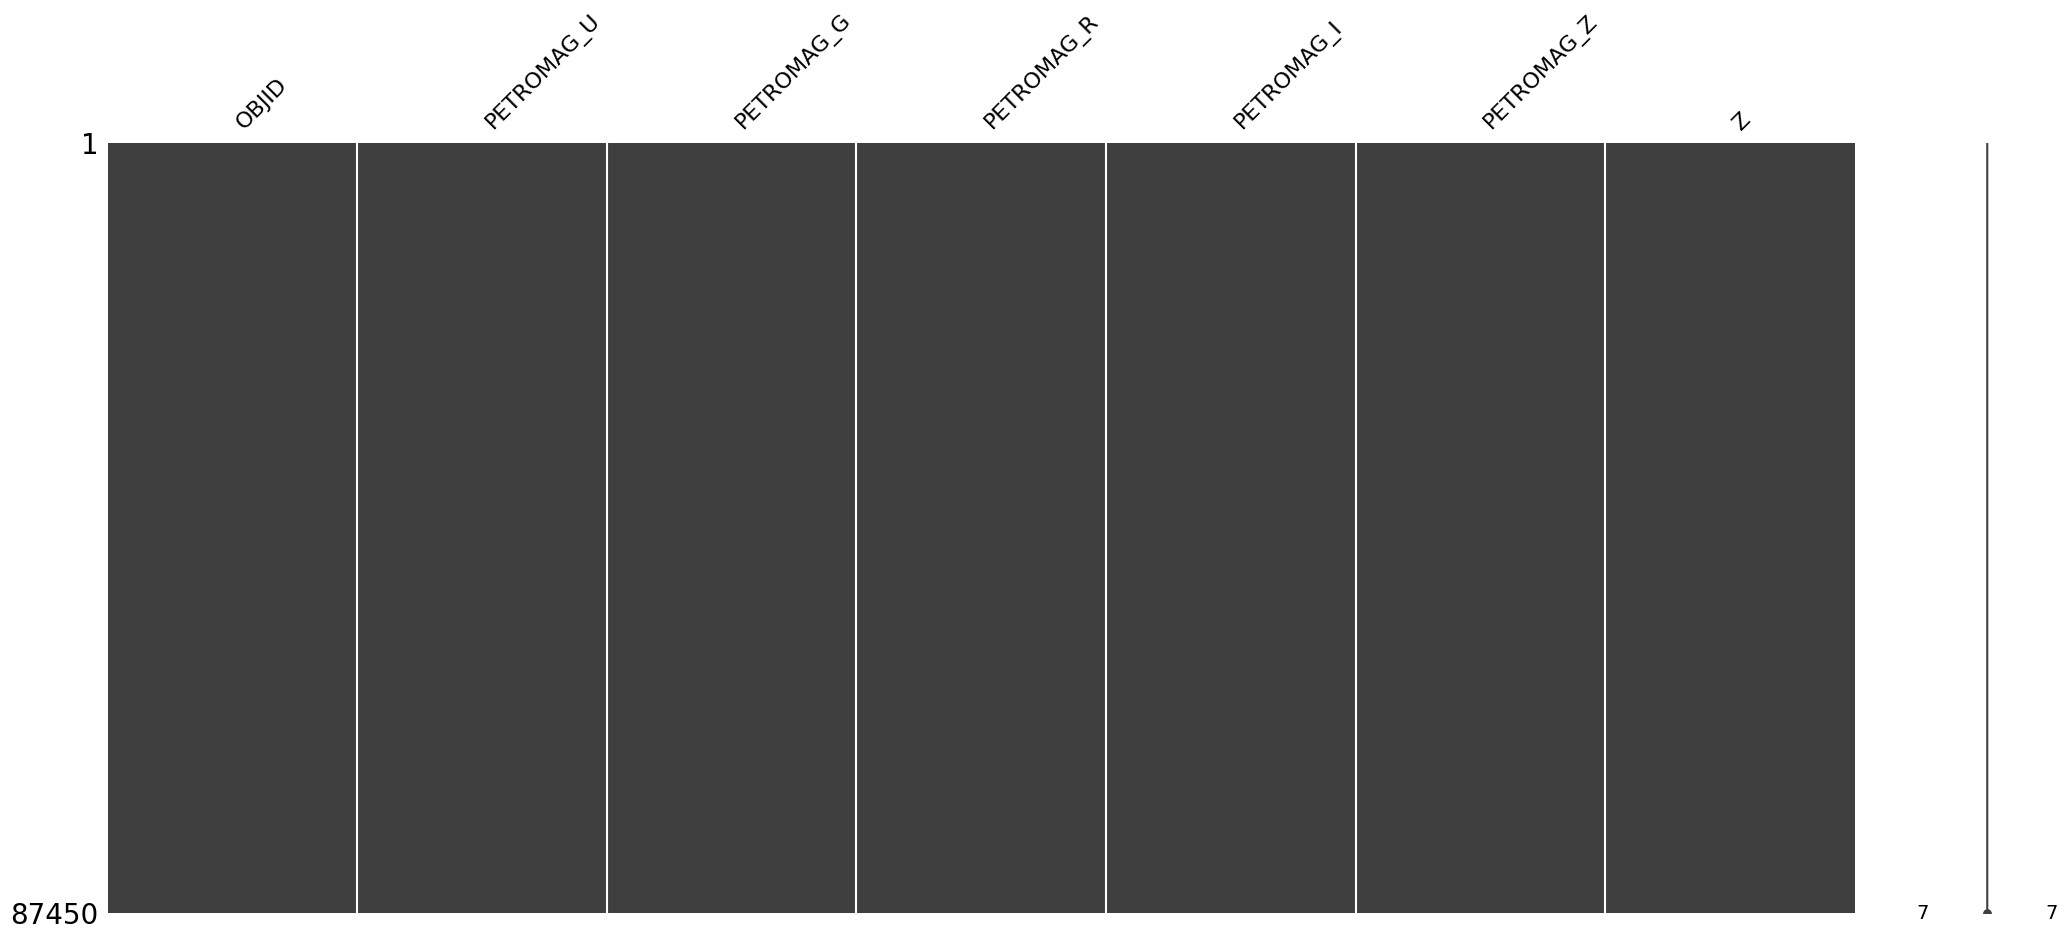

In [8]:
# Missing value analysis
import missingno

missingno.matrix(mag_df)

In [9]:
num_cols = ['PETROMAG_U', 'PETROMAG_G', 'PETROMAG_R', 'PETROMAG_I', 'PETROMAG_Z', 'Z']
feature_cols = ['PETROMAG_U', 'PETROMAG_G', 'PETROMAG_R', 'PETROMAG_I', 'PETROMAG_Z']
# correlation calculation
mag_df[num_cols].corr()

,PETROMAG_U,PETROMAG_G,PETROMAG_R,PETROMAG_I,PETROMAG_Z,Z
PETROMAG_U,1.000000,0.969380,0.975128,0.961427,0.205961,-0.066296
PETROMAG_G,0.969380,1.000000,0.989096,0.981153,0.209117,-0.101347
PETROMAG_R,0.975128,0.989096,1.000000,0.989467,0.211630,-0.095838
PETROMAG_I,0.961427,0.981153,0.989467,1.000000,0.211177,-0.105211
PETROMAG_Z,0.205961,0.209117,0.211630,0.211177,1.000000,-0.019246
Z,-0.066296,-0.101347,-0.095838,-0.105211,-0.019246,1.000000


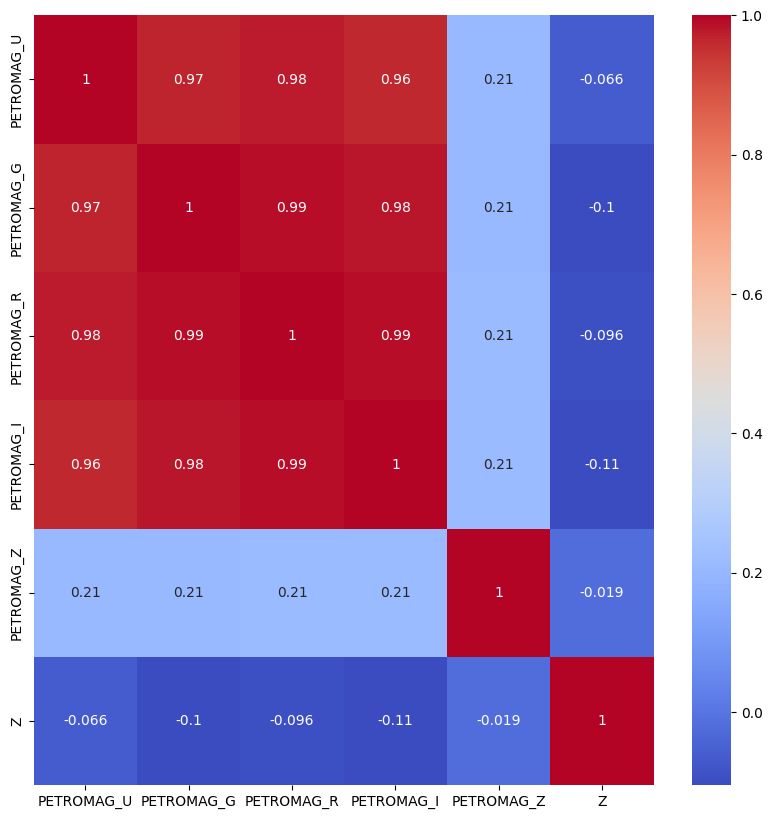

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
sns.heatmap(data=mag_df[num_cols].corr(), annot=True, cmap="coolwarm")
plt.savefig('f2_heatmap.png', dpi=300, bbox_inches='tight')
plt.show()

In [11]:
"""
for col in num_cols:
    print(f'{col} start')
    # 히스토그램 그리기
    sns.histplot(x=mag_df[col], bins=100)
    
    # 파일로 저장
    plt.savefig(f'f2_{col}_histplot.png', dpi=300, bbox_inches='tight')
    
    # 그래프 초기화
    plt.clf()  # 현재 그래프를 초기화하여 다음 반복을 위해 준비합니다.
    print(f'{col} done')

# 모든 작업이 끝난 후에 메모리에서 모든 플롯을 지웁니다.
plt.close('all')

import glob
import zipfile
import os

# 압축할 파일들이 있는 디렉토리 경로
directory = '/kaggle/working'

# 압축할 파일들의 확장자 (여기서는 PNG 파일만)
extension = '*.png'

# 압축 파일 이름
zip_file_name = '/kaggle/working/final_working_files.zip'

# PNG 파일들의 경로 가져오기
png_files = glob.glob(os.path.join(directory, extension))

# ZIP 파일 생성
with zipfile.ZipFile(zip_file_name, 'w') as zipf:
    for file in png_files:
        zipf.write(file, os.path.basename(file))

print(f'압축된 파일이 저장된 경로: {zip_file_name}')"""

"\nfor col in num_cols:\n    print(f'{col} start')\n    # 히스토그램 그리기\n    sns.histplot(x=mag_df[col], bins=100)\n    \n    # 파일로 저장\n    plt.savefig(f'f2_{col}_histplot.png', dpi=300, bbox_inches='tight')\n    \n    # 그래프 초기화\n    plt.clf()  # 현재 그래프를 초기화하여 다음 반복을 위해 준비합니다.\n    print(f'{col} done')\n\n# 모든 작업이 끝난 후에 메모리에서 모든 플롯을 지웁니다.\nplt.close('all')\n\nimport glob\nimport zipfile\nimport os\n\n# 압축할 파일들이 있는 디렉토리 경로\ndirectory = '/kaggle/working'\n\n# 압축할 파일들의 확장자 (여기서는 PNG 파일만)\nextension = '*.png'\n\n# 압축 파일 이름\nzip_file_name = '/kaggle/working/final_working_files.zip'\n\n# PNG 파일들의 경로 가져오기\npng_files = glob.glob(os.path.join(directory, extension))\n\n# ZIP 파일 생성\nwith zipfile.ZipFile(zip_file_name, 'w') as zipf:\n    for file in png_files:\n        zipf.write(file, os.path.basename(file))\n\nprint(f'압축된 파일이 저장된 경로: {zip_file_name}')"

In [12]:
mag_df['Z']

0         0.337797
1         0.273486
2       -99.000000
3         0.284007
4       -99.000000
           ...    
87445     0.366279
87446   -99.000000
87447     0.032769
87448     0.364290
87449     0.212936
Name: Z, Length: 87450, dtype: float64

#### -99가 무엇을 의미하는 것인지 불분명 -> Nan값을 -99로 넣은것으로 추정
- Label인 "Z"값이 -99인 행을 Testset으로 잡고 나머지를 Trainingset으로 설정

In [13]:
mag_df['OBJID']

0        1237661381695570379
1        1237661381695570380
2        1237661381695570634
3        1237661381695570691
4        1237661381695570866
                ...         
87445     588017978876297623
87446                     NN
87447                     NN
87448     587738946666954896
87449                     NN
Name: OBJID, Length: 87450, dtype: object

### 위 features를 모두 사용하여 Random forest를 적용

In [14]:
# Training set, Test set

# 데이터프레임 복사
train_dataset = mag_df.copy()
test_dataset = mag_df.copy()

# Z 컬럼 값이 -99인 행을 Test dataset으로 설정
test_dataset = test_dataset.loc[test_dataset['Z'] == -99]

# Z 컬럼 값이 -99이 아닌 행을 Train dataset으로 설정
train_dataset = train_dataset.loc[train_dataset['Z'] != -99]

print("Train dataset:")
print(train_dataset.shape)
print("\nTest dataset:")
print(test_dataset.shape)


Train dataset:
(20305, 7)

Test dataset:
(67145, 7)


In [15]:
rfc_target = mag_df['Z']
rfc_features = mag_df.drop(['Z'], axis=1)

In [16]:
rfc_X      = train_dataset.drop(['Z',], axis=1)
rfc_X_test = test_dataset.drop(['Z',], axis=1)
rfc_y      = train_dataset['Z']
rfc_y_test = test_dataset['Z']

In [17]:
rfc_y_test

2       -99.0
4       -99.0
6       -99.0
7       -99.0
8       -99.0
         ... 
87435   -99.0
87437   -99.0
87439   -99.0
87441   -99.0
87446   -99.0
Name: Z, Length: 67145, dtype: float64

In [18]:
rfc_X.shape, rfc_X_test.shape, rfc_y.shape, rfc_y_test.shape

((20305, 6), (67145, 6), (20305,), (67145,))

In [19]:
rfc_X.drop(columns='OBJID', inplace=True)
rfc_X_test.drop(columns='OBJID', inplace=True)

In [20]:
rfc_X_test

,PETROMAG_U,PETROMAG_G,PETROMAG_R,PETROMAG_I,PETROMAG_Z
2,24.547445,22.835169,21.154341,20.286835,20.287001
4,23.264183,22.053299,20.738749,19.300367,18.546480
6,21.927380,22.625257,22.155596,21.508535,21.462114
7,22.503593,22.175049,21.405785,20.905247,20.504675
8,23.774897,24.109764,22.952784,22.113880,21.137146
...,...,...,...,...,...
87435,-99.000000,-99.000000,-99.000000,-99.000000,-99.000000
87437,-99.000000,-99.000000,-99.000000,-99.000000,-99.000000
87439,-99.000000,-99.000000,-99.000000,-99.000000,-99.000000
87441,22.071505,22.604795,22.150223,20.588066,22.185753


## RandomForestRegressor(RFR)

In [21]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_squared_error
from scipy.stats import randint

In [22]:
# RandomForestRegressor 모델 정의
model = RandomForestRegressor()

# 탐색할 매개변수 공간 정의
params = {
    'n_estimators': [100, 200, 300, 400, 500, 600],
    'max_depth': randint(5, 20),  # 5에서 15 사이의 정수 랜덤 선택
    'min_samples_split': randint(2, 20),  # 2에서 10 사이의 정수 랜덤 선택
    'min_samples_leaf': randint(1, 10),  # 1에서 5 사이의 정수 랜덤 선택
    "max_leaf_nodes":range(10,31), "max_samples":np.arange(0.1, 1.1, 0.3)
}

# RandomizedSearchCV 설정
grid = RandomizedSearchCV(estimator=model, param_distributions=params, n_iter=100, cv=3, scoring="accuracy", verbose=1)

In [23]:
# 모델 훈련
grid.fit(rfc_X, rfc_y)

# 최적의 매개변수 출력
print("Best Parameters:", grid.best_params_)

# 최적의 모델 출력
best_model = grid.best_estimator_
print("Best Model:", best_model)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 234, in __call__
    return self._score(
  File "/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/opt/conda/lib/python3.10/site-packages/sklearn/utils/_param_validation.py", line 192, in wrapper
    return func(*args, **kwargs)
  File "/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py", line 221, in accuracy_score
    y_type, y_true, y_pred = _check_targets(y_true, y_pred)
 

Best Parameters: {'max_depth': 17, 'max_leaf_nodes': 22, 'max_samples': 0.4, 'min_samples_leaf': 6, 'min_samples_split': 13, 'n_estimators': 100}
Best Model: RandomForestRegressor(max_depth=17, max_leaf_nodes=22, max_samples=0.4,
                      min_samples_leaf=6, min_samples_split=13)


In [24]:
# 최적의 모델로 예측 수행
predictions = best_model.predict(rfc_X_test)

# 예측 결과 출력
print("Predictions:", predictions)
print(len(predictions))

Predictions: [0.4178267  0.39745754 0.7957596  ... 0.13155996 0.72845234 0.13155996]
67145


In [25]:
all_df = mag_df[feature_cols]
all_df

,PETROMAG_U,PETROMAG_G,PETROMAG_R,PETROMAG_I,PETROMAG_Z
0,21.323261,20.854404,19.707392,19.273945,18.714960
1,20.935017,20.528833,19.854614,19.613590,19.129480
2,24.547445,22.835169,21.154341,20.286835,20.287001
3,21.752686,21.104000,20.348263,20.078228,19.590927
4,23.264183,22.053299,20.738749,19.300367,18.546480
...,...,...,...,...,...
87445,21.476429,20.743719,19.748775,19.168179,19.000887
87446,-99.000000,-99.000000,-99.000000,-99.000000,-99.000000
87447,-99.000000,-99.000000,-99.000000,-99.000000,-99.000000
87448,20.450430,19.570396,18.469381,17.996925,17.653069


In [26]:
predicted_PM_Z = best_model.predict(all_df)

In [27]:
Z_data = {"OBJID": mag_df['OBJID'],
        "Z": mag_df['Z'],
        "predicted_PM_Z": predicted_PM_Z
       }

In [28]:
Z_df = pd.DataFrame(Z_data)
Z_df

,OBJID,Z,predicted_PM_Z
0,1237661381695570379,0.337797,0.281949
1,1237661381695570380,0.273486,0.302839
2,1237661381695570634,-99.000000,0.417827
3,1237661381695570691,0.284007,0.316009
4,1237661381695570866,-99.000000,0.397458
...,...,...,...
87445,588017978876297623,0.366279,0.277166
87446,NN,-99.000000,0.131560
87447,NN,0.032769,0.131560
87448,587738946666954896,0.364290,0.170659


In [29]:
Z_df=Z_df.loc[Z_df['Z'] != -99]
Z_df

,OBJID,Z,predicted_PM_Z
0,1237661381695570379,0.337797,0.281949
1,1237661381695570380,0.273486,0.302839
3,1237661381695570691,0.284007,0.316009
5,1237661381695569927,0.308064,0.301260
25,1237661381695570026,0.273614,0.326846
...,...,...,...
87444,587739115781030336,0.196604,0.508990
87445,588017978876297623,0.366279,0.277166
87447,NN,0.032769,0.131560
87448,587738946666954896,0.364290,0.170659


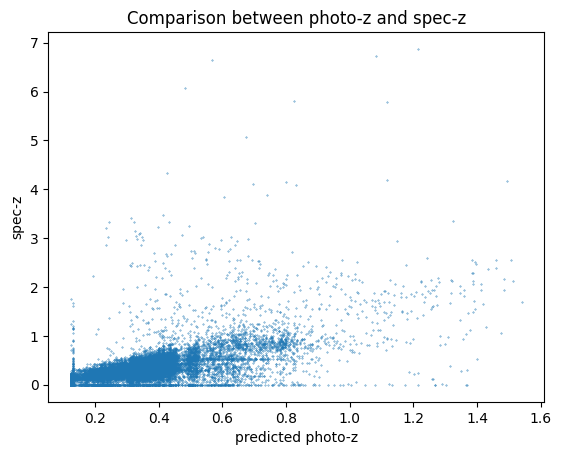

In [34]:
# Scatter Plot

plt.scatter(Z_df['predicted_PM_Z'], Z_df['Z'], s=0.1)
plt.xlabel('predicted photo-z')
plt.ylabel('spec-z')
# Save the plot as a PNG file
plt.savefig('Comparison.png')
plt.title('Comparison between photo-z and spec-z')
plt.show()

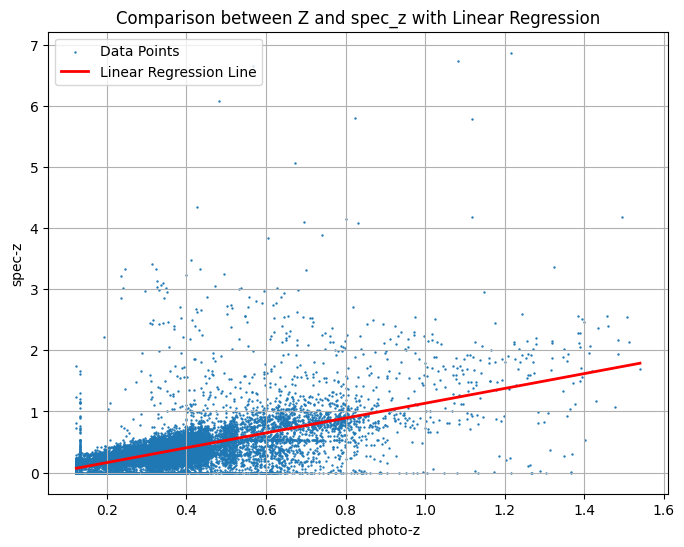

In [35]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

# Assume Z_df['Z'] and Z_df['spec_z'] are pandas Series
x = Z_df['predicted_PM_Z'].to_numpy()  # Convert to numpy array
y = Z_df['Z'].to_numpy()  # Convert to numpy array

# 선형 회귀 모델 훈련
model = LinearRegression()
model.fit(x.reshape(-1, 1), y)  # Reshape x as a numpy array before fitting

# 회귀선을 그리기 위한 x 값 범위 설정
x_range = np.linspace(min(x), max(x), 100).reshape(-1, 1)

# 회귀선 예측
y_pred = model.predict(x_range)

# 산점도와 회귀선 그리기
plt.figure(figsize=(8, 6))
plt.scatter(x, y, label='Data Points', s=0.5)
plt.plot(x_range, y_pred, color='red', linewidth=2, label='Linear Regression Line')
plt.xlabel('predicted photo-z')
plt.ylabel('spec-z')
plt.title('Comparison between Z and spec_z with Linear Regression')
plt.legend()
plt.grid(True)
plt.savefig('Comparison_linear.png')
plt.show()

In [32]:
# 상관 계수 (Correlation Coefficient)
import numpy as np

correlation = np.corrcoef(Z_df['predicted_PM_Z'], Z_df['Z'])[0, 1]
print(f'Correlation coefficient: {correlation}')


Correlation coefficient: 0.5764105408779724


In [33]:
# 통계적 검정
from scipy.stats import ttest_ind

statistic, p_value = ttest_ind(Z_df['predicted_PM_Z'], Z_df['Z'])
print(f'T-test statistic: {statistic}, p-value: {p_value}')


T-test statistic: -0.09365373728002985, p-value: 0.9253846830248531
